# Introduction


In this notebook, we implement [The TensorFlow 2 Object Detection Library](https://blog.tensorflow.org/2020/07/tensorflow-2-meets-object-detection-api.html) for training on your own dataset.

We also recommend reading our blog post on [Train TensorFlow 2 Object Detection on custom data](https://blog.roboflow.com/train-a-tensorflow2-object-detection-model/) side by side.

We will take the following steps to implement YOLOv4 on our custom data:
* Install TensorFlow2 Object Detection Dependencies
* Download Custom TensorFlow2 Object Detection Dataset
* Use Trained TensorFlow2 Object Detection For Inference on Test Images


# Install TensorFlow2 Object Detection Dependencies

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
!git clone --depth 1 https://github.com/jhadden25/WheresWaldo
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'WheresWaldo'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 52 (delta 8), reused 51 (delta 8), pack-reused 0
Unpacking objects: 100% (52/52), done.
Checking out files: 100% (40/40), done.
Cloning into 'models'...
remote: Enumerating objects: 2605, done.
remote: Counting objects: 100% (2605/2605), done.
remote: Compressing objects: 100% (2164/2164), done.
remote: Total 2605 (delta 648), reused 1247 (delta 407), pack-reused 0
Receiving objects: 100% (2605/2605), 32.57 MiB | 31.79 MiB/s, done.
Resolving deltas: 100% (648/648), done.


IMPORTANT!
-------------------------------------------------------------------------------
Now you MUST refresh the project hierarchy on the left and move each folder from within the 'WheresWaldo' folder out into the working directory before continuing.
-------------------------------------------------------------------------------

In [2]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1647299 sha256=9ef679758f0a9fad7f396caeaeb3431366c565a47b69ee487a89a405ffcb13ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-8e0tg0io/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=8034ec7e4e43517445db3c12900044c973893121443c9edd9a042944c91c30e9
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=6de87b7975fae8d7e1d6cbe6a4966c3e484e6a70e2482e6df7c0eeb38477f74d
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=0355ffdfee0320da2af400d7f660a25a313458d425c4e5cc948d

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.29.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [3]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [4]:
#run model builder test
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py


2021-04-29 07:35:04.914264: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2021-04-29 07:35:07.635517: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-29 07:35:07.660084: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-29 07:35:07.733809: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-04-29 07:35:07.733867: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (92aa7d02a0a4): /proc/driver/nvidia/version does not exist
2021-04-29 07:35:07.734365: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devic

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [ ]:
##change chosen model to deploy different models available in the TF2 object detection zoo
MODELS_CONFIG = {
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d2_768x768_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
        'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
        'batch_size': 16
    }
}

#in this tutorial we implement the lightweight, smallest state of the art efficientdet model
#if you want to scale up tot larger efficientdet models you will likely need more compute!
chosen_model = 'efficientdet-d0'

num_steps = 2000 #The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 #Perform evaluation after so many steps

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your training

In [ ]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = '/content/valid/Waldo.tfrecord'
train_record_fname = '/content/train/Waldo.tfrecord'
label_map_pbtxt_fname = '/content/train/Waldo_label_map.pbtxt'

In [ ]:
#download pretrained weights
%mkdir /content/models/research/deploy/
%cd /content/models/research/deploy/
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

/content/models/research/deploy
--2021-04-29 07:19:00--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.216.128, 2607:f8b0:400c:c12::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.216.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M   180MB/s    in 0.2s    

2021-04-29 07:19:01 (180 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]



In [ ]:
#download base training configuration file
%cd /content/models/research/deploy
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

/content/models/research/deploy
--2021-04-29 07:19:05--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4630 (4.5K) [text/plain]
Saving to: ‘ssd_efficientdet_d0_512x512_coco17_tpu-8.config’

ssd_efficientdet_d0 100%[===================>]   4.52K  --.-KB/s    in 0s      

2021-04-29 07:19:05 (46.8 MB/s) - ‘ssd_efficientdet_d0_512x512_coco17_tpu-8.config’ saved [4630/4630]



In [ ]:
%cd /content/train


/content/train


In [ ]:
#prepare
pipeline_fname = '/content/models/research/deploy/' + base_pipeline_file
fine_tune_checkpoint = '/content/models/research/deploy/' + model_name + '/checkpoint/ckpt-0'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)


In [ ]:
#write custom configuration file by slotting our dataset, model checkpoint, and training parameters into the base pipeline file

import re

%cd /content/models/research/deploy
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    #fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
        
    f.write(s)



/content/models/research/deploy
writing custom configuration file


In [ ]:
pipeline_file = '/content/models/research/deploy/pipeline_file.config'
model_dir = '/content/training/'

# Convert Custom TF2 Object Detector

* pipeline_file: defined above in writing custom training configuration
* model_dir: the location tensorboard logs and saved model checkpoints will save to
* num_train_steps: how long to train for
* num_eval_steps: perform eval on validation set after this many steps







In [ ]:
#see where our model saved weights
%ls '/content/training/'

checkpoint                  ckpt-2.data-00000-of-00001  ckpt-3.index
ckpt-1.data-00000-of-00001  ckpt-2.index
ckpt-1.index                ckpt-3.data-00000-of-00001


In [ ]:
#run conversion script
import re
import numpy as np

output_directory = '/content/fine_tuned_model'

#place the model weights you would like to export here
last_model_path = '/content/training/'
print(last_model_path)
!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

/content/training/
2021-04-29 07:21:20.058404: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-29 07:21:22.840692: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-29 07:21:22.841904: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-29 07:21:22.853891: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-04-29 07:21:22.853962: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (59f685cd630e): /proc/driver/nvidia/version does not exist
2021-04-29 07:21:22.854630: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
I0429 07:21:22.862304 139968850175872 ssd_efficientnet_bi

In [ ]:
%ls '/content/fine_tuned_model/saved_model/'

assets/  saved_model.pb  variables/


# Run Inference on Test Images with Custom TensorFlow2 Object Detector

In [5]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [6]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [7]:
import pathlib

filenames = list(pathlib.Path('/content/training/').glob('*.index'))

filenames.sort()
print(filenames)

#recover our saved model
pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

[]


NameError: ignored

In [ ]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

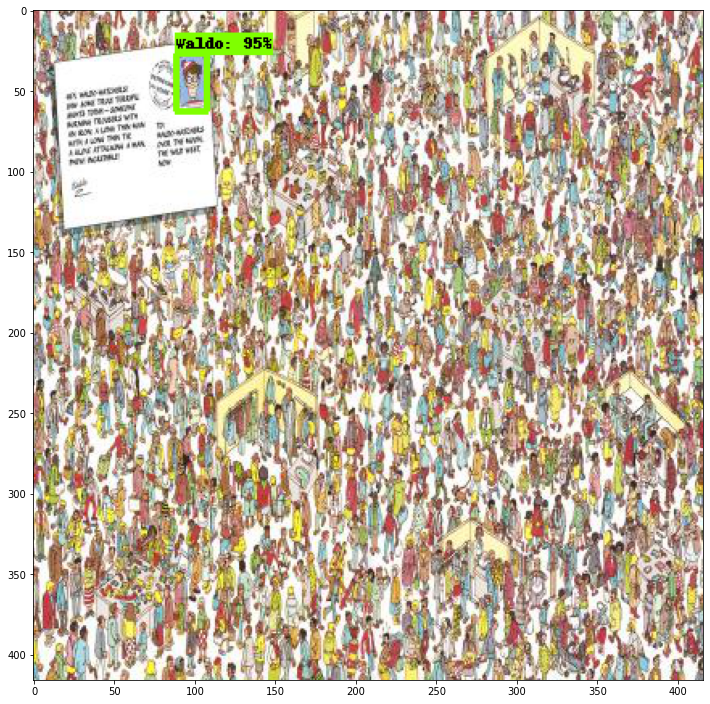

In [ ]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

TEST_IMAGE_PATHS = glob.glob('/content/test/test/*.jpg')
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.5,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

## Congrats!

Hope you enjoyed this!

--Team [Roboflow](https://roboflow.ai)
